# Reading & Understanding Data

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import os
import IPython

seed = 42
np.random.seed(seed) 
# random.seed(seed)

In [2]:
sub_dir = './data/2x10x3/'

### About the dataset

In [3]:
from src.database import Database

db = Database(sub_dir)
df = db.df

In [4]:
df.head()

,filename,length,chroma_stft1_var,chroma_stft1_mean,chroma_stft2_var,chroma_stft2_mean,chroma_stft3_var,chroma_stft3_mean,chroma_stft4_var,chroma_stft4_mean,...,mfcc16_mean,mfcc17_var,mfcc17_mean,mfcc18_var,mfcc18_mean,mfcc19_var,mfcc19_mean,mfcc20_var,mfcc20_mean,label
0,02TcHmrc537505824TcdnbMp3.0,63078.0,0.0,0.321759,0.0,0.726720,0.0,0.437948,0.0,0.330802,...,0.428932,36.298618,-5.597476,26.766903,1.345605,72.489861,3.253771,52.741318,7.256914,Dancefloor
1,02TcHmrc537505824TcdnbMp3.1,66150.0,0.0,0.400691,0.0,0.712579,0.0,0.392655,0.0,0.356017,...,0.619886,34.498959,-5.697873,26.557186,1.491368,60.791534,3.364270,49.549961,7.211648,Dancefloor
2,02TcHmrc537505824TcdnbMp3.2,66150.0,0.0,0.365667,0.0,0.726458,0.0,0.392244,0.0,0.339426,...,0.902030,37.598709,-4.868746,27.333706,1.729364,57.242455,3.563363,49.324142,7.353123,Dancefloor
3,02TcHmrc537505824TcdnbMp3.3,66150.0,0.0,0.354951,0.0,0.729517,0.0,0.375555,0.0,0.314484,...,0.959917,40.387730,-5.363005,27.478460,1.599809,63.194485,4.483665,49.474102,7.462634,Dancefloor
4,02TcHmrc537505824TcdnbMp3.4,66150.0,0.0,0.363629,0.0,0.726587,0.0,0.386118,0.0,0.321845,...,0.409469,36.123070,-5.523437,28.101028,1.638596,57.930973,4.229635,49.811298,7.914058,Dancefloor


In [5]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (180, 82)
Count of Positive and Negative samples


,index,label
0,Dancefloor,20
1,Deep,20
2,Jungle,20
3,Liquid,20
4,Minimal,20
5,Neurofunk,20
6,Sambass,20
7,Shriek,20
8,Techno,20


# Data Preparation

Treat missing values.
Outlier Treatment
Define dummy variables for categorical variables.

### Missing Value Treatment

In [6]:
# find all columns with any NA values
df.drop(['length'], axis=1, inplace=True)

print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


### Encode Genre Label

In [7]:
# map labels to index
label_index = {}
index_label = {}
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'Dancefloor': 0, 'Deep': 1, 'Jungle': 2, 'Liquid': 3, 'Minimal': 4, 'Neurofunk': 5, 'Sambass': 6, 'Shriek': 7, 'Techno': 8}
{0: 'Dancefloor', 1: 'Deep', 2: 'Jungle', 3: 'Liquid', 4: 'Minimal', 5: 'Neurofunk', 6: 'Sambass', 7: 'Shriek', 8: 'Techno'}


In [8]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

### Split Train, Dev & Test Sets

In [14]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [15]:
# remove irrelevant columns
df_shuffle.drop(['filename'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle


# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [16]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 125 records out of 180 which is 69%
Dev set has 36 records out of 180 which is 20%
Test set has 19 records out of 180 which is 11%


In [17]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

11.200000000000001
11.11111111111111
10.526315789473683


In [23]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [24]:
# y_train = np.array([train_labels_idx[x] for x in y_train.index.tolist()])
# y_test = np.array([train_labels_idx[x] for x in y_test.index.tolist()])
# y_train[::10]

#### Scale the Features

In [25]:
# # scale features
# scaler = skp.MinMaxScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
# test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)
# print(X_train.shape)

# Model Building

In [26]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.8.0


In [27]:

def trainModel(model, epochs, optimizer):
    # [32, 64] - CPU
    # [128, 256] - GPU for more boost
    batch_size = 32
    
    # Stop training when a monitored metric has stopped improving.
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [28]:
model = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(len(label_index.keys()), activation='softmax'),
])
print(model.summary())
history = trainModel(model=model, epochs=100, optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               40960     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

Max. Validation Accuracy 1.0


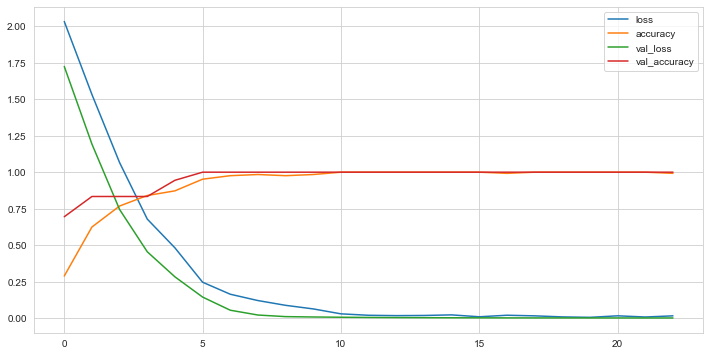

In [29]:
plotHistory(history)

In [30]:
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

1/1 [==============================] - 0s 105ms/step - loss: 2.7658e-04 - accuracy: 1.0000
The test Loss is : 0.00027657634927891195

The Best test Accuracy is : 100.0


In [32]:
import pickle
import joblib

model.save( os.path.join(sub_dir, "model.h5"))

joblib.dump(scaler , os.path.join(sub_dir, "scaler.pkl"))     # save to disk

with open(os.path.join(sub_dir, "labels.pkl"), "wb") as a_file:
    pickle.dump(index_label, a_file)